In [2]:
# Import required libraries, functions, and modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoLars, LinearRegression, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import wrangle
import explore

import warnings
warnings.filterwarnings("ignore")

# Project Objective

### The goal of this project was to predict property tax assessed values of Single Family Properties located in three counties (LA, Orange, and Ventura) in southern California that had a transaction in 2017. 

# Wrangle Zillow Data

- The wrangle_zillow function in the wrangle.py module is used to acquire and prepare the data from the mySQL server or cached csv file. Approximately 52000 rows are returned for the Single Family property type.
- The data is prepared by performing the following:
    - Renaming columns
    - Filling in NaN values for columns such as whether the house has a pool or garage
    - Creating additional feature columns such as:
        - Home age
        - Living space
        - Room count
        - Categorizing bathroom and bedroom counts

In [31]:
df = wrangle.wrangle_zillow()
df.shape

Using cached data


(52442, 19)

- To help focus exploration and modeling on the bulk of the data outliers are removed:

In [32]:
df_outlier_removed = wrangle.remove_outliers_std(df, 2.0, ['tax_value','lot_size','bedroom','bathroom','living_space'])
df_outlier_removed = df_outlier_removed.dropna()
df_outlier_removed.shape

Number of observations removed: 4652


(47509, 19)

- The data were split into train, validate, and test sets

In [59]:
train, validate, test = wrangle.split_data(df_outlier_removed)

Data split as follows: Train 56.00%, Validate 24.00%, Test 20.00%


### The target variable distribution is shown in the following histogram. 

(9.0, 15.0)

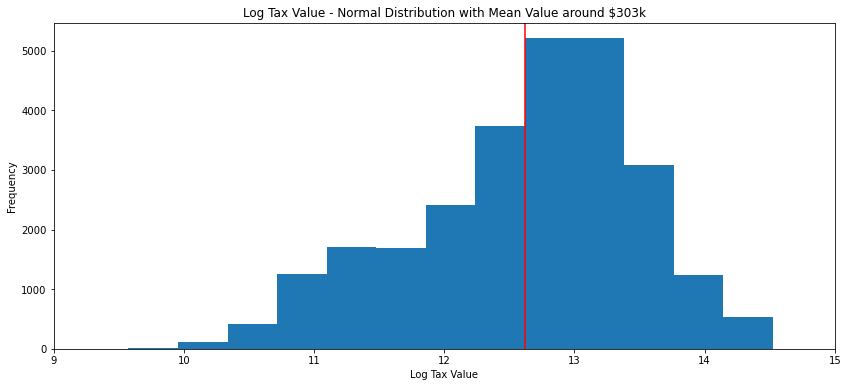

In [71]:
np.log(train.tax_value).plot.hist(bins=20, figsize = (14,6))
plt.xlabel("Log Tax Value")
plt.axvline(np.log(train.tax_value).mean(), color = 'red')
plt.title(f"Log Tax Value - Normal Distribution with Mean Value around $303k")
plt.xlim(9,15)

## Key Drivers of Property Value for Single Family Properties
- Location:
    - Does the property's county affect the tax value?
- Home Size and Usable Space
    - Does the property's square footage affect the tax value?
    - Does the number of bedrooms or number of bathrooms affect the tax value?
    - Does the space outside of bedrooms and bathrooms affect the tax value?
- Age and Condition
    - How does the age of the house affect the tax value?

### Location: does the property's county affects it's tax value?
-> Perform 1 sample t-test

Generating plots tax_value by county


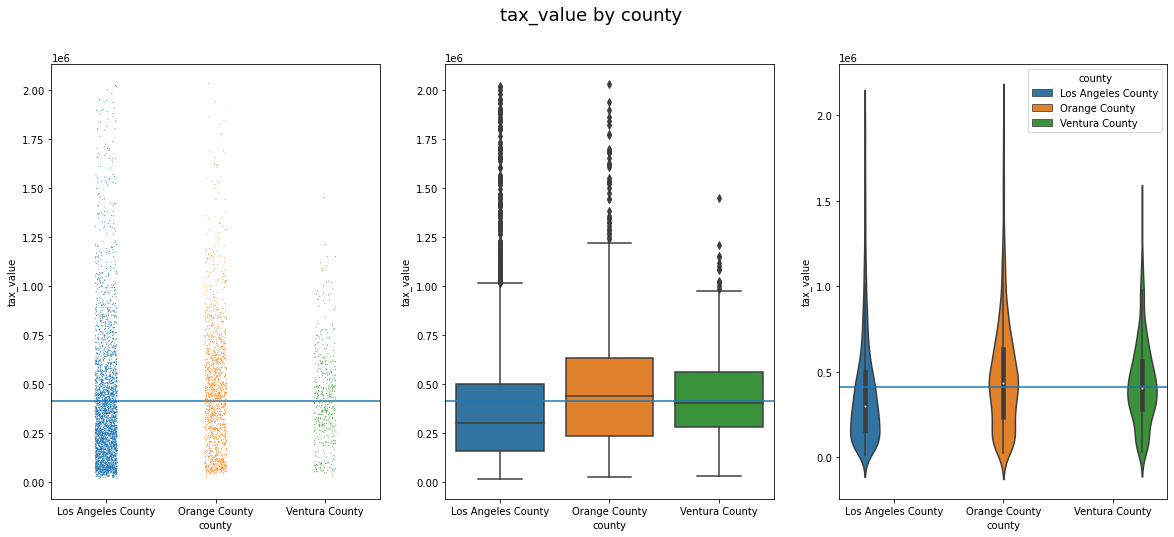

In [66]:
explore.plot_categorical_and_continuous_vars(train, ['county'], ['tax_value'], sample_amt = 5000)

In [70]:
alpha = 0.05
for county in set(train.county):
    sample = train.tax_value[train.county == county]
    t, p = stats.ttest_1samp(sample, train.tax_value.mean())
    if (p/2 < alpha) and (t>0):
        print(county, " t: ", round(t,2), "Significantly Greater")
        
    t, p = stats.ttest_1samp(sample, train.tax_value.mean())
    
    if (p/2 < alpha) and (t<0):
        print(county, round(t,2), "Significantly Less")

Orange County  t:  17.69 Significantly Greater
Los Angeles County -12.46 Significantly Less
Ventura County  t:  5.23 Significantly Greater


### Based on the t-test results LA County has an average tax value significantly lower than the overall average, while Orange and Ventura counties have higher average tax values. 
- The county will be used as a feature for the model.

## Home Size and Usable Space
- Does the property's square footage affect the tax value?
- Does the number of bedrooms or number of bathrooms affect the tax value?
- Does the space outside of bedrooms and bathrooms affect the tax value?
    - This is defined as Square Footage - (40 * Num Bathrooms) - (200 * Num Bedrooms)

-> Pearson Correlation Test Performed

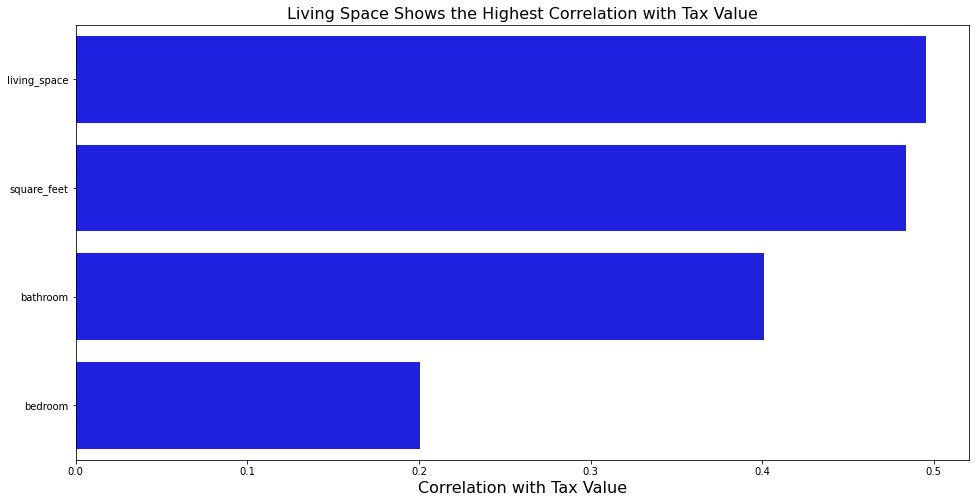

In [137]:
# Plot correlation of living space features to tax value
of_interest = ['tax_value','living_space','square_feet','bathroom','bedroom']
corrs = pd.DataFrame(train[of_interest].drop(columns = ['tax_value']).corrwith(train.tax_value, method = 'pearson').sort_values(ascending=False), columns = ["Correlation"])
plt.figure(figsize = (16,8))
sns.barplot(data = corrs, y = corrs.index, x = corrs.Correlation, color = 'b')
plt.xlabel("Correlation with Tax Value", fontsize = 16)
p=plt.title("Living Space Shows the Highest Correlation with Tax Value", fontsize = 16)

### Both living space and square footage correlate moderately with tax value, with could affect model performance due to multicollinearity. 

## Age and Condition: How does the age of the house affect the tax value?
- Is this affected by the property's county?

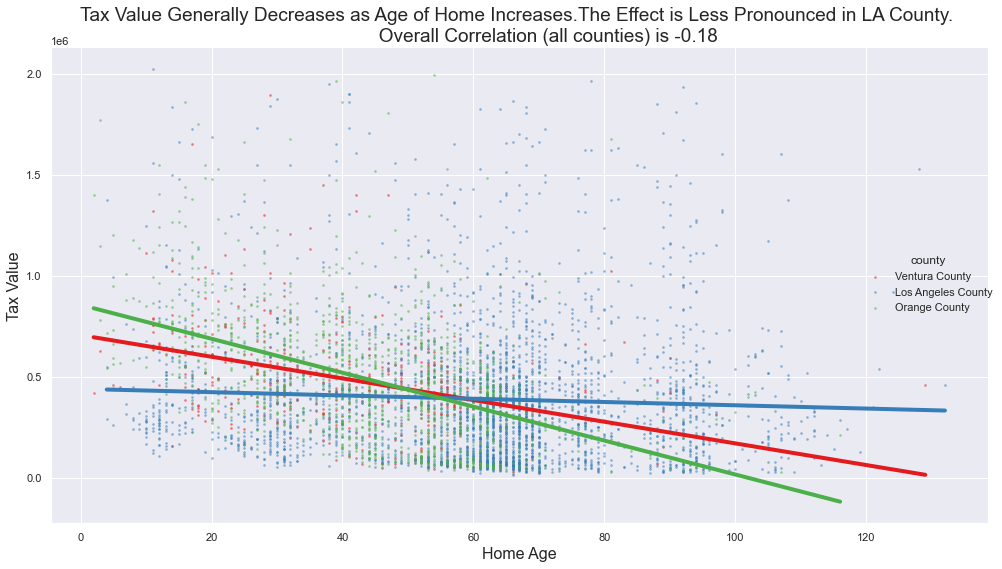

In [200]:
sns.lmplot(data = train.sample(5000), x = 'age', y = 'tax_value', hue = 'county',palette='Set1',
                           scatter_kws={"alpha":0.4, 's':3}, 
                           line_kws={'lw':4},
                           ci = None, height = 8, aspect = 1.5)

plt.title(f"Tax Value Generally Decreases as Age of Home Increases.The Effect is Less Pronounced in LA County. \n \
          Overall Correlation (all counties) is {round(train.corrwith(train.tax_value, method = 'pearson')['age'],2)}", fontsize = 19)
plt.tight_layout()
plt.xlabel('Home Age', fontsize = 16)
plt.ylabel('Tax Value', fontsize = 16)
plt.show()

### Age has a weakly linear correlation with tax value overall, though the property's county affects this relationship.